In [1]:
import gym
import gym_anytrading

from finta import TA

from stable_baselines3.common.vec_env import DummyVecEnv
from gym_anytrading.envs import ForexEnv
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from stable_baselines3 import PPO,A2C

C:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
df = pd.read_csv("EURUSD_H4_202401020000_202412311200.csv",delimiter='\t')
df['Datetime'] = pd.to_datetime(df['<DATE>'] + ' ' + df['<TIME>'])
df = df.drop(columns=['<VOL>', '<DATE>', '<TIME>'])
df.set_index('Datetime',inplace=True)


df.rename(columns={
    '<CLOSE>': 'Close',
    '<OPEN>': 'Open',
    '<HIGH>': 'High',
    '<LOW>': 'Low',
    '<TICKVOL>': 'Volume',
    '<SPREAD>': 'Spread'
}, inplace=True)

df['SMA'] = TA.SMA(df,12)
df['RSI'] = TA.RSI(df)
df['OBV'] = TA.OBV(df)
df.fillna(0,inplace=True)

df.dtypes


Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
Spread      int64
SMA       float64
RSI       float64
OBV       float64
dtype: object

In [3]:
df

,Open,High,Low,Close,Volume,Spread,SMA,RSI,OBV
Datetime,,,,,,,,,
2024-01-02 00:00:00,1.10437,1.10451,1.10340,1.10347,10037,1,0.000000,0.000000,0.0
2024-01-02 04:00:00,1.10348,1.10358,1.10163,1.10331,17127,1,0.000000,0.000000,-17127.0
2024-01-02 08:00:00,1.10332,1.10389,1.10108,1.10152,36734,0,0.000000,0.000000,-53861.0
2024-01-02 12:00:00,1.10150,1.10171,1.09492,1.09528,47781,0,0.000000,0.000000,-101642.0
2024-01-02 16:00:00,1.09527,1.09684,1.09407,1.09506,68980,0,0.000000,0.000000,-170622.0
...,...,...,...,...,...,...,...,...,...
2024-12-30 20:00:00,1.03944,1.04070,1.03937,1.04030,5263,0,1.041584,46.357149,-54039.0
2024-12-31 00:00:00,1.04039,1.04132,1.03940,1.04120,3078,0,1.041576,49.823657,-50961.0
2024-12-31 04:00:00,1.04120,1.04148,1.04024,1.04038,2912,1,1.041530,46.852863,-53873.0


In [4]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt

class TRYForexEnv(gym.Env):
    def __init__(self, df, window_size):
        super(TRYForexEnv, self).__init__()
        self.df = df
        self.window_size = window_size
        self.current_step = window_size
        self.balance = 1000  # Initial balance
        self.position = None  # None, "buy", "sell"
        self.entry_price = 0
        self.volume = 0  # New attribute to track volume
        self.trades = []

        # Action space: 0 = open buy, 1 = open sell, 2 = close buy, 3 = close sell, 4 = hold
        self.action_space = spaces.Discrete(5)

        # Observation space: [price data + indicators]
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(window_size, len(df.columns)), dtype=np.float32
        )

    def reset(self):
        self.current_step = self.window_size
        self.balance = 1000
        self.position = None
        self.entry_price = 0
        self.volume = 0
        self.trades = []
        return self._get_observation()

    def step(self, action):
        done = False
        reward = 0
        current_price = self.df['Close'].iloc[self.current_step]

        if action == 0:  # Open Buy
            if self.position is None:
                self.position = "buy"
                self.entry_price = current_price
                self.volume = 1  # Start with 1 unit
                self.trades.append((self.current_step, "buy", current_price))
                print('เปิด buy 1 volume, ที่ราคา',current_price)
            elif self.position == "buy":
                # Add volume to existing buy position
                self.volume += 1
                self.entry_price = ((self.entry_price * (self.volume - 1)) + current_price) / self.volume
                self.trades.append((self.current_step, "buy", current_price))
                print('ซื้อ buy เพิ่ม เป็น',self.volume,' volume, ที่ราคา',current_price,'เฉลี่ย = ',self.entry_price)
                
            else:
                reward = -1
                #ลงโทษสำหรับ buy -> sell (ต้องปิดก่อน)
                
        elif action == 1:  # Open Sell
            if self.position is None:
                self.position = "sell"
                self.entry_price = current_price
                self.volume = 1  # Start with 1 unit
                self.trades.append((self.current_step, "sell", current_price))
                print('เปิด sell 1 volume, ที่ราคา',current_price)
            elif self.position == "sell":
                # Add volume to existing sell position
                self.volume += 1
                self.entry_price = ((self.entry_price * (self.volume - 1)) + current_price) / self.volume
                self.trades.append((self.current_step, "sell", current_price))
                print('ซื้อ sell เพิ่ม เป็น',self.volume,' volume, ที่ราคา',current_price,'เฉลี่ย = ',self.entry_price)
                
            else:
                reward = -1
                #ลงโทษสำหรับ sell -> buy (ต้องปิดก่อน)

        elif action == 2:  # Close Buy
            if self.position == "buy":
                reward = (current_price - self.entry_price) * self.volume
                self.balance += reward
                self.trades.append((self.current_step, "close_buy", current_price))
                print("ปิด buy ที่ราคา",current_price,"จำนวน",self.volume,"ได้กำไร",reward)
                print("----------------------")
                self.position = None
                self.volume = 0

        elif action == 3:  # Close Sell
            if self.position == "sell":
                reward = (self.entry_price - current_price) * self.volume
                self.balance += reward
                self.trades.append((self.current_step, "close_sell", current_price))
                print("ปิด sell ที่ราคา",current_price,"จำนวน",self.volume,"ได้กำไร",reward)
                print("----------------------")
                self.position = None
                self.volume = 0

        elif action == 4:  # Hold
            # No changes to position or balance, simply hold
            reward = -0.1

        # Update to next step
        self.current_step += 1
        if self.current_step >= len(self.df) - 1:
            done = True

        obs = self._get_observation()
        info = {"balance": self.balance, "volume": self.volume}
        return obs, reward, done, info

    def _get_observation(self):
        return self.df.iloc[self.current_step - self.window_size:self.current_step].values

    def render(self):
        print(f"Step: {self.current_step}, Balance: {self.balance}, Position: {self.position}, Volume: {self.volume}")

    def plot_trades(self):
        plt.figure(figsize=(15, 6))
        plt.plot(self.df.index, self.df['Close'], label='Close Price', color='blue')

        for step, action, price in self.trades:
            if action == "buy":
                plt.scatter(self.df.index[step], price, color='green', label='Buy', marker='^')
            elif action == "sell":
                plt.scatter(self.df.index[step], price, color='pink', label='Sell', marker='v')
            elif action == "close_buy":
                plt.scatter(self.df.index[step], price, color='red', label='Close Buy', marker='o')
            elif action == "close_sell":
                plt.scatter(self.df.index[step], price, color='orange', label='Close Sell', marker='o')

        # Adjust axes for better visualization
        plt.xlim(self.df.index[0], self.df.index[-1])
        plt.ylim(self.df['Close'].min() * 0.95, self.df['Close'].max() * 1.05)

        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(), loc="upper left")

        plt.title("Forex Trading Actions")
        plt.xlabel("Time Steps")
        plt.ylabel("Price")
        plt.grid()
        plt.show()

เปิด buy 1 volume, ที่ราคา 1.09676
ปิด buy ที่ราคา 1.09435 จำนวน 1 ได้กำไร -0.0024100000000000232
----------------------
เปิด buy 1 volume, ที่ราคา 1.09128
ซื้อ buy เพิ่ม เป็น 2  volume, ที่ราคา 1.09215 เฉลี่ย =  1.091715
ซื้อ buy เพิ่ม เป็น 3  volume, ที่ราคา 1.09408 เฉลี่ย =  1.0925033333333334
ซื้อ buy เพิ่ม เป็น 4  volume, ที่ราคา 1.09375 เฉลี่ย =  1.092815
ซื้อ buy เพิ่ม เป็น 5  volume, ที่ราคา 1.0937 เฉลี่ย =  1.0929920000000002
ซื้อ buy เพิ่ม เป็น 6  volume, ที่ราคา 1.09508 เฉลี่ย =  1.0933400000000002
ซื้อ buy เพิ่ม เป็น 7  volume, ที่ราคา 1.09646 เฉลี่ย =  1.0937857142857144
ปิด buy ที่ราคา 1.09441 จำนวน 7 ได้กำไร 0.004370000000000207
----------------------
เปิด buy 1 volume, ที่ราคา 1.09321
ปิด buy ที่ราคา 1.09638 จำนวน 1 ได้กำไร 0.003169999999999895
----------------------
เปิด buy 1 volume, ที่ราคา 1.09509
ซื้อ buy เพิ่ม เป็น 2  volume, ที่ราคา 1.09716 เฉลี่ย =  1.0961249999999998
ซื้อ buy เพิ่ม เป็น 3  volume, ที่ราคา 1.09826 เฉลี่ย =  1.0968366666666665
ซื้อ buy เพิ่ม เป็น

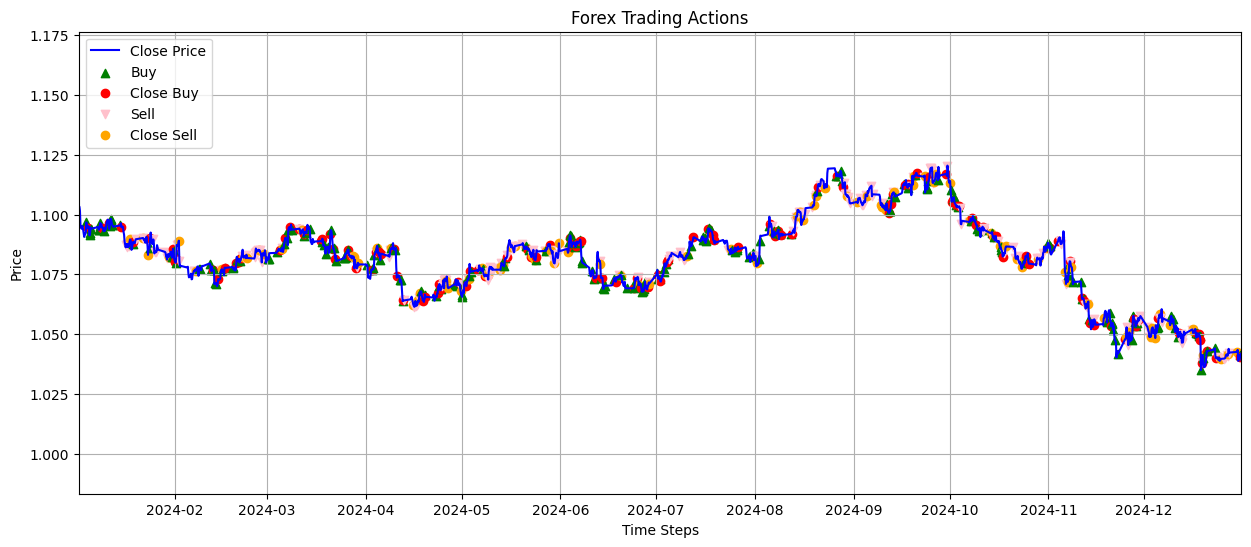

In [5]:
env = TRYForexEnv(df=df[0:], window_size=12)
obs = env.reset()

done = False
while not done:
    action = env.action_space.sample()  # Random action
    obs, reward, done, info = env.step(action)
env.plot_trades()

In [6]:
env_maker = lambda: TRYForexEnv(df=df[:5000], window_size=12)
env4= DummyVecEnv([env_maker])

C:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [7]:
from stable_baselines3.common.callbacks import EvalCallback


eval_callback = EvalCallback(
    env4,  # Environment สำหรับการประเมินผล
    best_model_save_path='./best_model2/',  # ที่เก็บโมเดลที่ดีที่สุด
    log_path='./logs/',  # ที่เก็บ logs
    eval_freq=5000,  # ความถี่ในการประเมินผล
    deterministic=True,  # ใช้ deterministic policy
    render=False,  # ไม่ต้องแสดงการแสดงผล
)

# สร้าง PPO model
model = PPO('MlpPolicy', env4, verbose=1)

# เรียนรู้โดยใช้ eval_callback
model.learn(total_timesteps=30000, callback=eval_callback)

Using cpu device
เปิด buy 1 volume, ที่ราคา 1.09265
ปิด buy ที่ราคา 1.09471 จำนวน 1 ได้กำไร 0.002060000000000173
----------------------
เปิด buy 1 volume, ที่ราคา 1.09435
ซื้อ buy เพิ่ม เป็น 2  volume, ที่ราคา 1.09128 เฉลี่ย =  1.0928149999999999
ซื้อ buy เพิ่ม เป็น 3  volume, ที่ราคา 1.09215 เฉลี่ย =  1.0925933333333333
ปิด buy ที่ราคา 1.09462 จำนวน 3 ได้กำไร 0.006079999999999863
----------------------
เปิด buy 1 volume, ที่ราคา 1.09479
ปิด buy ที่ราคา 1.0937 จำนวน 1 ได้กำไร -0.0010900000000000354
----------------------
เปิด sell 1 volume, ที่ราคา 1.09646
ซื้อ sell เพิ่ม เป็น 2  volume, ที่ราคา 1.09496 เฉลี่ย =  1.09571
ปิด sell ที่ราคา 1.09614 จำนวน 2 ได้กำไร -0.0008599999999998609
----------------------
เปิด sell 1 volume, ที่ราคา 1.09441
ปิด sell ที่ราคา 1.09462 จำนวน 1 ได้กำไร -0.00020999999999982144
----------------------
เปิด buy 1 volume, ที่ราคา 1.09321
ซื้อ buy เพิ่ม เป็น 2  volume, ที่ราคา 1.09322 เฉลี่ย =  1.093215
ซื้อ buy เพิ่ม เป็น 3  volume, ที่ราคา 1.09718 เฉลี่ย =  1.

C:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


เปิด sell 1 volume, ที่ราคา 1.1168
ปิด sell ที่ราคา 1.10249 จำนวน 1 ได้กำไร 0.014310000000000045
----------------------
เปิด buy 1 volume, ที่ราคา 1.11229
ซื้อ buy เพิ่ม เป็น 2  volume, ที่ราคา 1.11243 เฉลี่ย =  1.11236
ซื้อ buy เพิ่ม เป็น 3  volume, ที่ราคา 1.11446 เฉลี่ย =  1.11306
ปิด buy ที่ราคา 1.10346 จำนวน 3 ได้กำไร -0.028799999999999493
----------------------
เปิด sell 1 volume, ที่ราคา 1.1168
ปิด sell ที่ราคา 1.10249 จำนวน 1 ได้กำไร 0.014310000000000045
----------------------
เปิด buy 1 volume, ที่ราคา 1.11229
ซื้อ buy เพิ่ม เป็น 2  volume, ที่ราคา 1.11243 เฉลี่ย =  1.11236
ซื้อ buy เพิ่ม เป็น 3  volume, ที่ราคา 1.11446 เฉลี่ย =  1.11306
ปิด buy ที่ราคา 1.10346 จำนวน 3 ได้กำไร -0.028799999999999493
----------------------
เปิด sell 1 volume, ที่ราคา 1.1168
ปิด sell ที่ราคา 1.10249 จำนวน 1 ได้กำไร 0.014310000000000045
----------------------
เปิด buy 1 volume, ที่ราคา 1.11229
ซื้อ buy เพิ่ม เป็น 2  volume, ที่ราคา 1.11243 เฉลี่ย =  1.11236
ซื้อ buy เพิ่ม เป็น 3  volume, ที่ราคา 1